In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

#Get the ISO-Codes
iso = pd.read_csv("../Data/ISO/ISO.csv")

In [2]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../Data/Networks/W_1_ij.csv', '../Data/Networks/W_2_ij.csv', '../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../Data/Networks/W_3_ij.csv as W_3_ij


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 81353, Filtered rows: 69127
Filtered W_2_ij. Original rows: 34585, Filtered rows: 29382
Filtered W_3_ij. Original rows: 94775, Filtered rows: 78649


In [4]:
#Explanatory Dataframe will be 2002 of Cap 1
TN_t_c = W_ij_dataframes["W_1_ij"][W_ij_dataframes["W_1_ij"]["period"] == 2002]


PageRank for 2002:
    Country  PageRank
0       DEU  0.146868
1       ESP  0.105692
2       USA  0.059427
3       NOR  0.043864
4       NLD  0.041821
..      ...       ...
172     MYT  0.001014
173     TGO  0.001014
174     SYC  0.001014
175     VCT  0.001014
176     WSM  0.001014

[177 rows x 2 columns]


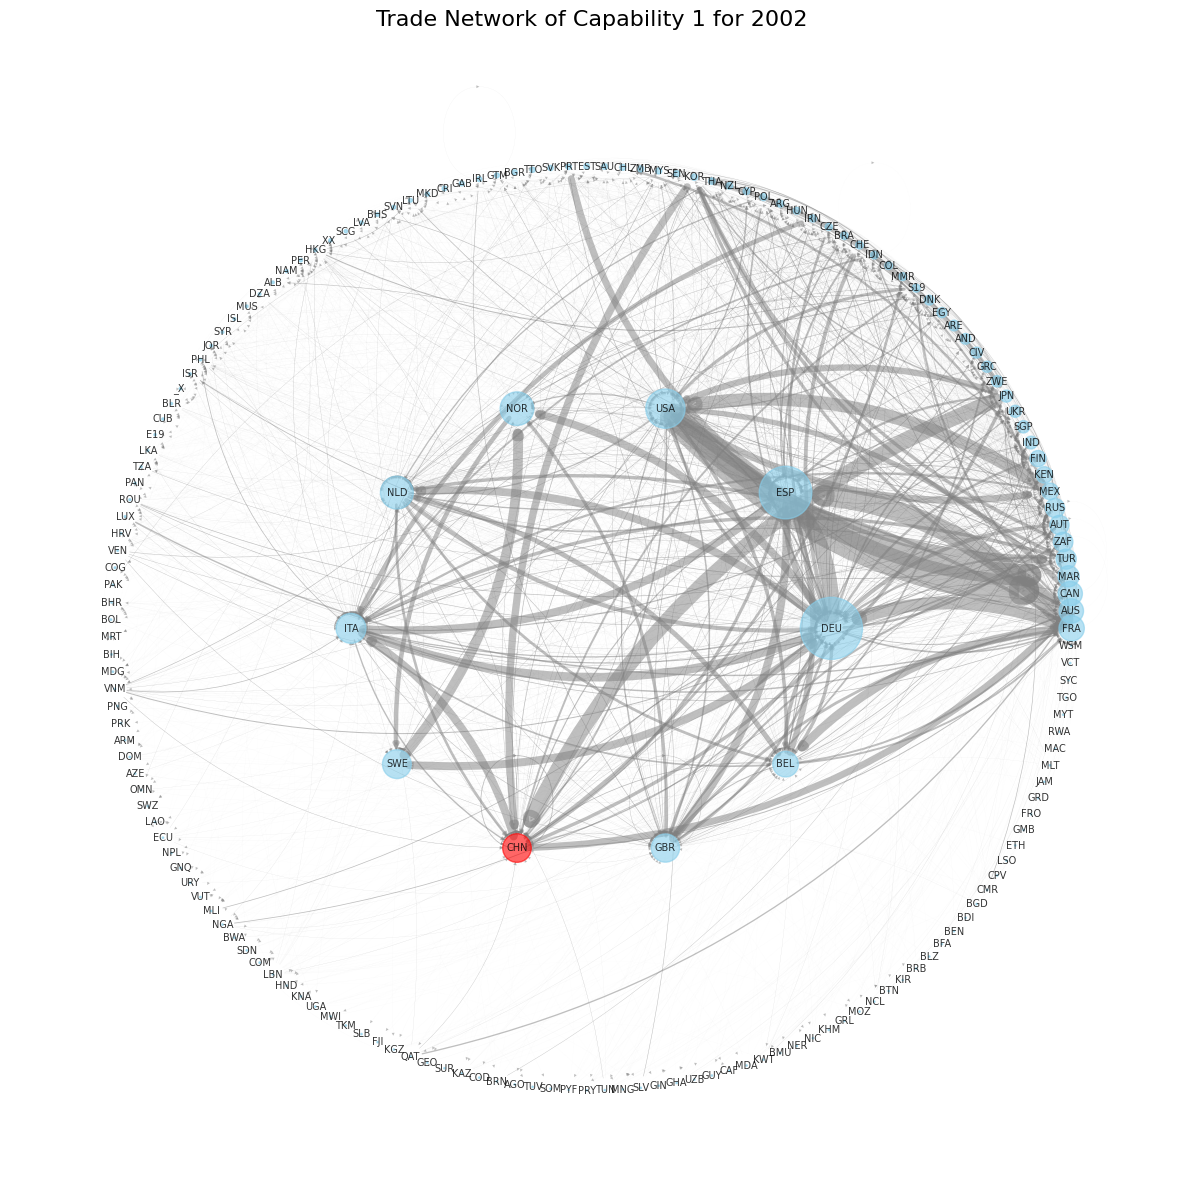

In [5]:
# --- 1. PageRank Calculation for a Single Period ---
def calculate_pagerank(TN_t_c):
    """Calculates PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    P = M_row_stochastic.T # Column-stochastic matrix for PageRank

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c

# Get PageRank for the 2002 data
pagerank_2002_1 = calculate_pagerank(TN_t_c)
print("\nPageRank for 2002:")
print(pagerank_2002_1)


# --- 2. Create Custom Layout and Visualization ---
def visualize_network(TN_t_c, pagerank_t_c, top_n=10, period_val=2000, cap=1):
    G = nx.DiGraph()

    # Add edges with weights
    for index, row in TN_t_c.iterrows():
        reporter = row['reporterISO']
        partner = row['partnerISO']
        weight = row['W_ij']
        G.add_edge(reporter, partner, weight=weight)

    if not G.nodes():
        print(f"No network data found for period {period_val}. Cannot visualize.")
        return

    # Filter out nodes from PageRank_df that are not in the current graph
    # This can happen if some countries are in pagerank_df but not active in the current df_period
    # (though for this specific function call, it should be consistent)
    active_nodes = list(G.nodes())
    pagerank_t_c_active = pagerank_t_c[pagerank_t_c['Country'].isin(active_nodes)].copy()

    # Identify top N and other countries
    if len(pagerank_t_c_active) > top_n:
        top_countries_df = pagerank_t_c_active.head(top_n)
        other_countries_df = pagerank_t_c_active.iloc[top_n:].copy()
        # Sort others by PageRank for consistent circle order
        other_countries_df = other_countries_df.sort_values(by='PageRank', ascending=False)
    else:
        # If fewer than top_n countries, all are considered "top" and will be centered
        top_countries_df = pagerank_t_c_active
        other_countries_df = pd.DataFrame(columns=['Country', 'PageRank']) # Empty

    # --- Calculate Custom Positions ---
    pos = {}
    
    # Parameters for layout
    center_radius = 1  # Radius for the central cluster
    outer_radius = 2.0   # Radius for the outer circle
    num_top = len(top_countries_df)
    num_others = len(other_countries_df)

    # Position for top countries (small circle in the center)
    for i, country in enumerate(top_countries_df['Country']):
        angle = 2 * math.pi * i / num_top if num_top > 0 else 0
        x = center_radius * math.cos(angle)
        y = center_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # Position for other countries (larger circle)
    for i, country in enumerate(other_countries_df['Country']):
        angle = 2 * math.pi * i / num_others if num_others > 0 else 0
        x = outer_radius * math.cos(angle)
        y = outer_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # --- Drawing ---
    plt.figure(figsize=(15, 15))

    # Node sizes 
    node_pageranks = pagerank_t_c_active.set_index('Country')['PageRank']
    max_pr = node_pageranks.max() #Get maximum PageRank
    min_pr = node_pageranks.min() #Get minimum PageRank
    
    # Scale node size for better visibility, making higher PR nodes larger
    node_sizes = [
        1 + 2000 * ((node_pageranks[node] - min_pr) / (max_pr - min_pr + 1e-9))
        for node in G.nodes()
    ] if len(node_pageranks) > 1 else [2000 for _ in G.nodes()]


    # Node colors: Differentiate top countries
    node_colors = ['red' if node == "CHN" else 'skyblue' for node in G.nodes()]

    # Edge widths based on W_ij
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0

    # Scale edge width for better visibility
    edge_widths = [
        0.01 + 20 * ((w - min_weight) / (max_weight - min_weight + 1e-9))
        for w in edge_weights
    ] if len(edge_weights) > 1 else [2.0 for _ in G.edges()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.6)

    # Draw edges
    nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='grey',
    arrows=True,
    arrowstyle='-|>',
    arrowsize=5,  # Increased for better visibility
    width=edge_widths,
    connectionstyle="arc3,rad=0.2",  # More curve
    alpha=0.5,
    min_source_margin=0,
    min_target_margin=10
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="normal", alpha=0.8)

    plt.title(f'Trade Network of Capability {cap} for {period_val}', size=16)
    plt.axis('off') # Hide axes
    plt.show()

# Visualize the 2002 network with custom layout
visualize_network(TN_t_c, pagerank_2002_1, top_n=10, period_val=2002) # Adjusted top_n to 3 due to small sample size

In [6]:
def calculate_pagerank_export(TN_t_c):
    """Calculates Export PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    # M_row_stochastic where M_ij = W_ij / sum(W_ik for k)
    # This represents the probability of exporting from i to j
    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    
    # Handle dangling nodes (countries with no outgoing exports)
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    # For export PageRank, the transition matrix P should be M_row_stochastic itself
    # because the formula sums over j (receiving country) for each i (exporting country)
    # weighted by W_ij / sum(W_ik).
    # If r is a column vector, then M_row_stochastic @ r is NOT the correct operation for this formula.
    # The formula is r_i = alpha * SUM_j (M_ij * r_j)
    # This means (P_export @ r)_i = sum_j (P_export)_ij * r_j
    # So P_export should be M_row_stochastic
    # However, numpy's matmul (@) is row vector @ matrix or matrix @ column vector.
    # The standard PageRank formulation expects P to be column-stochastic, and r to be column vector.
    # If P is column stochastic (P_ji = prob of j -> i), then r_i = sum_j P_ji * r_j.
    # Our M_row_stochastic has M_ij = W_ij / sum_k W_ik. This is the probability of i -> j.
    # So to get sum_j M_ij r_j, we would need to multiply a row vector r by M_row_stochastic.
    # OR, we need a column-stochastic matrix which is M_row_stochastic.T.
    # Let's verify with the formula.
    # The formula looks like a left multiplication by r_j.
    # r_new_i = alpha * sum_j (M_ij * r_j) + (1-alpha)/n
    # If r is a column vector, this is (M_row_stochastic * r)_i
    # So, P should be M_row_stochastic.
    P = M_row_stochastic 

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        # r_new = alpha * P @ r + (1 - alpha) * v
        # Since P is M_row_stochastic (P_ij = W_ij / sum_k W_ik), and r is a column vector,
        # (P @ r)_i = sum_j P_ij * r_j. This exactly matches the desired formula's summation.
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c


PageRank for 2002:
    Country  PageRank
0       DEU  0.146868
1       ESP  0.105692
2       USA  0.059427
3       NOR  0.043864
4       NLD  0.041821
..      ...       ...
172     MYT  0.001014
173     TGO  0.001014
174     SYC  0.001014
175     VCT  0.001014
176     WSM  0.001014

[177 rows x 2 columns]


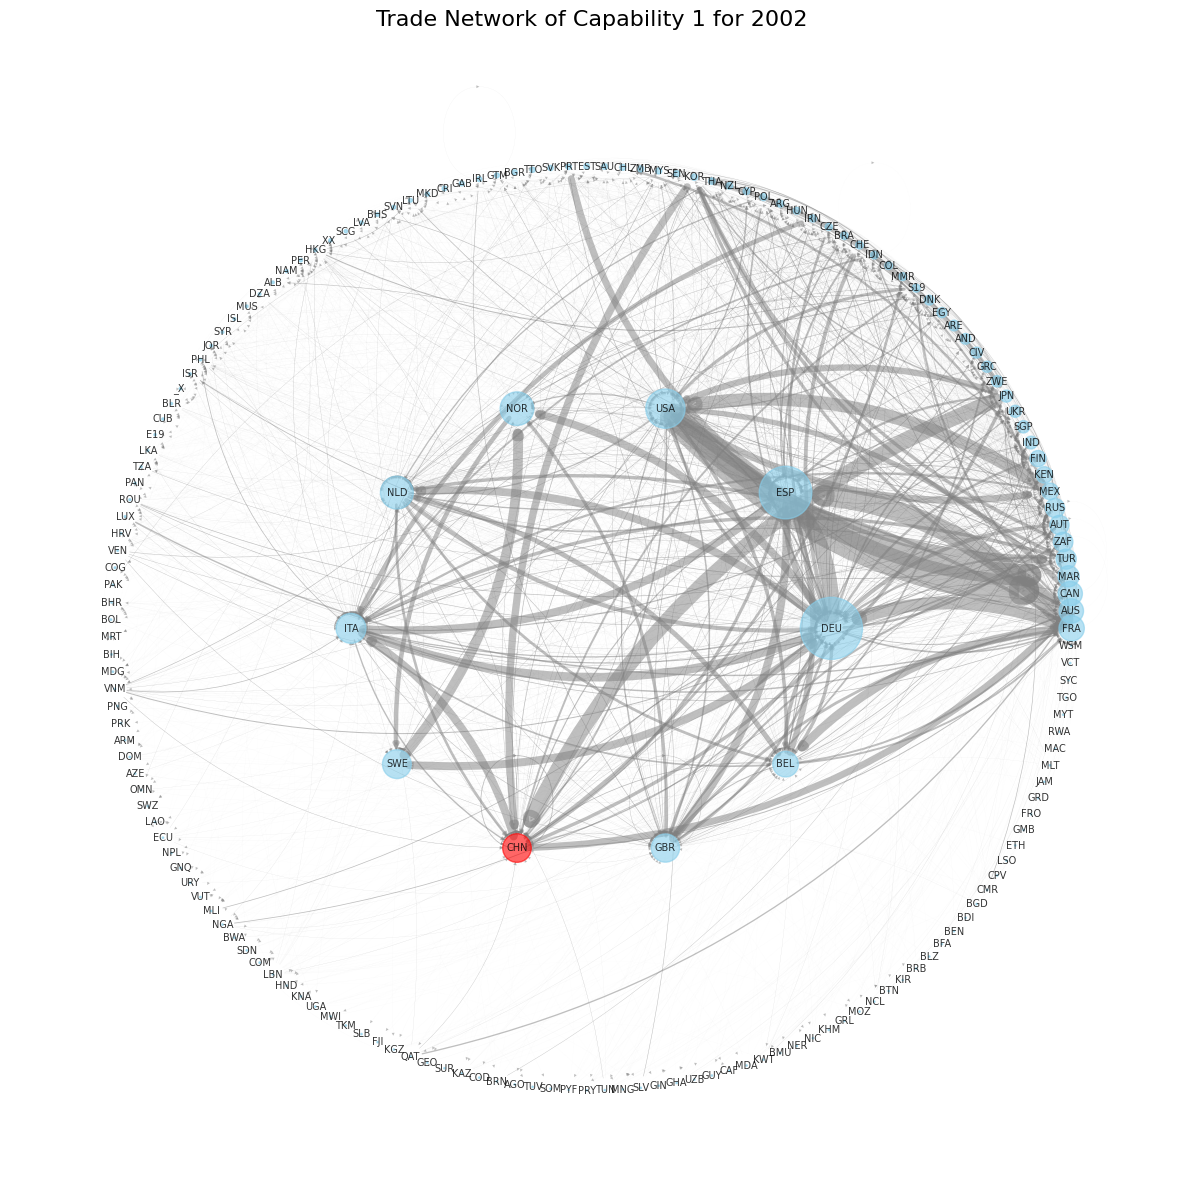

In [7]:
# --- 1. PageRank Calculation for a Single Period ---
def calculate_pagerank(TN_t_c):
    """Calculates PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    P = M_row_stochastic.T # Column-stochastic matrix for PageRank

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c

# Get PageRank for the 2002 data
pagerank_2002_1 = calculate_pagerank(TN_t_c)
print("\nPageRank for 2002:")
print(pagerank_2002_1)


# --- 2. Create Custom Layout and Visualization ---
def visualize_network(TN_t_c, pagerank_t_c, top_n=10, period_val=2000, cap=1):
    G = nx.DiGraph()

    # Add edges with weights
    for index, row in TN_t_c.iterrows():
        reporter = row['reporterISO']
        partner = row['partnerISO']
        weight = row['W_ij']
        G.add_edge(reporter, partner, weight=weight)

    if not G.nodes():
        print(f"No network data found for period {period_val}. Cannot visualize.")
        return

    # Filter out nodes from PageRank_df that are not in the current graph
    # This can happen if some countries are in pagerank_df but not active in the current df_period
    # (though for this specific function call, it should be consistent)
    active_nodes = list(G.nodes())
    pagerank_t_c_active = pagerank_t_c[pagerank_t_c['Country'].isin(active_nodes)].copy()

    # Identify top N and other countries
    if len(pagerank_t_c_active) > top_n:
        top_countries_df = pagerank_t_c_active.head(top_n)
        other_countries_df = pagerank_t_c_active.iloc[top_n:].copy()
        # Sort others by PageRank for consistent circle order
        other_countries_df = other_countries_df.sort_values(by='PageRank', ascending=False)
    else:
        # If fewer than top_n countries, all are considered "top" and will be centered
        top_countries_df = pagerank_t_c_active
        other_countries_df = pd.DataFrame(columns=['Country', 'PageRank']) # Empty

    # --- Calculate Custom Positions ---
    pos = {}
    
    # Parameters for layout
    center_radius = 1  # Radius for the central cluster
    outer_radius = 2.0   # Radius for the outer circle
    num_top = len(top_countries_df)
    num_others = len(other_countries_df)

    # Position for top countries (small circle in the center)
    for i, country in enumerate(top_countries_df['Country']):
        angle = 2 * math.pi * i / num_top if num_top > 0 else 0
        x = center_radius * math.cos(angle)
        y = center_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # Position for other countries (larger circle)
    for i, country in enumerate(other_countries_df['Country']):
        angle = 2 * math.pi * i / num_others if num_others > 0 else 0
        x = outer_radius * math.cos(angle)
        y = outer_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # --- Drawing ---
    plt.figure(figsize=(15, 15))

    # Node sizes 
    node_pageranks = pagerank_t_c_active.set_index('Country')['PageRank']
    max_pr = node_pageranks.max() #Get maximum PageRank
    min_pr = node_pageranks.min() #Get minimum PageRank
    
    # Scale node size for better visibility, making higher PR nodes larger
    node_sizes = [
        1 + 2000 * ((node_pageranks[node] - min_pr) / (max_pr - min_pr + 1e-9))
        for node in G.nodes()
    ] if len(node_pageranks) > 1 else [2000 for _ in G.nodes()]


    # Node colors: Differentiate top countries
    node_colors = ['red' if node == "CHN" else 'skyblue' for node in G.nodes()]

    # Edge widths based on W_ij
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0

    # Scale edge width for better visibility
    edge_widths = [
        0.01 + 20 * ((w - min_weight) / (max_weight - min_weight + 1e-9))
        for w in edge_weights
    ] if len(edge_weights) > 1 else [2.0 for _ in G.edges()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.6)

    # Draw edges
    nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='grey',
    arrows=True,
    arrowstyle='-|>',
    arrowsize=5,  # Increased for better visibility
    width=edge_widths,
    connectionstyle="arc3,rad=0.2",  # More curve
    alpha=0.5,
    min_source_margin=0,
    min_target_margin=10
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="normal", alpha=0.8)

    plt.title(f'Trade Network of Capability {cap} for {period_val}', size=16)
    plt.axis('off') # Hide axes
    plt.show()

# Visualize the 2002 network with custom layout
visualize_network(TN_t_c, pagerank_2002_1, top_n=10, period_val=2002) # Adjusted top_n to 3 due to small sample size

In [8]:

#Does all the pictures


# --- 1. PageRank Calculation for a Single Period ---
def calculate_pagerank(TN_t_c):
    """Calculates PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    # Handle division by zero for row_sums
    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0, out=np.zeros_like(W))
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    P = M_row_stochastic.T # Column-stochastic matrix for PageRank

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c

# --- 2. Create Custom Layout and Visualization ---
def visualize_network(TN_t_c, pagerank_t_c, top_n=10, period_val=2000, cap=0, ax=None):
    """
    Visualizes the trade network for a given period and capability.
    It plots the network on a provided matplotlib axis.
    """
    G = nx.DiGraph()

    # Add edges with weights
    for index, row in TN_t_c.iterrows():
        reporter = row['reporterISO']
        partner = row['partnerISO']
        weight = row['W_ij']
        G.add_edge(reporter, partner, weight=weight)

    if not G.nodes():
        if ax:
            ax.set_title(f"No data for Cap {cap}, Period {period_val}", size=10)
            ax.set_xticks([])
            ax.set_yticks([])
        return

    # Filter out nodes from PageRank_df that are not in the current graph
    active_nodes = list(G.nodes())
    pagerank_t_c_active = pagerank_t_c[pagerank_t_c['Country'].isin(active_nodes)].copy()

    # Identify top N and other countries
    if len(pagerank_t_c_active) > top_n:
        top_countries_df = pagerank_t_c_active.head(top_n)
        other_countries_df = pagerank_t_c_active.iloc[top_n:].copy()
        other_countries_df = other_countries_df.sort_values(by='PageRank', ascending=False)
    else:
        top_countries_df = pagerank_t_c_active
        other_countries_df = pd.DataFrame(columns=['Country', 'PageRank']) # Empty

    # --- Calculate Custom Positions ---
    pos = {}
    
    # Parameters for layout
    center_radius = 1 # Radius for the central cluster
    outer_radius = 2.0 # Radius for the outer circle
    num_top = len(top_countries_df)
    num_others = len(other_countries_df)

    # Position for top countries (small circle in the center)
    for i, country in enumerate(top_countries_df['Country']):
        angle = 2 * math.pi * i / num_top if num_top > 0 else 0
        x = center_radius * math.cos(angle)
        y = center_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # Position for other countries (larger circle)
    for i, country in enumerate(other_countries_df['Country']):
        angle = 2 * math.pi * i / num_others if num_others > 0 else 0
        x = outer_radius * math.cos(angle)
        y = outer_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # --- Drawing ---
    # Ensure an axis is provided for plotting
    if ax is None:
        raise ValueError("An 'ax' (matplotlib axes object) must be provided to visualize_network.")

    # Node sizes 
    node_pageranks = pagerank_t_c_active.set_index('Country')['PageRank']
    max_pr = node_pageranks.max() if not node_pageranks.empty else 1 # Get maximum PageRank, default to 1 if empty
    min_pr = node_pageranks.min() if not node_pageranks.empty else 0 # Get minimum PageRank, default to 0 if empty
    
    # Scale node size for better visibility, making higher PR nodes larger
    # Add a small epsilon to denominator to avoid division by zero if max_pr == min_pr
    node_sizes = [
        1 + 2000 * ((node_pageranks[node] - min_pr) / (max_pr - min_pr + 1e-9))
        for node in G.nodes()
    ] if len(node_pageranks) > 1 else [2000 for _ in G.nodes()]


    # Node colors: Differentiate top countries
    node_colors = ['red' if node == "CHN" else 'skyblue' for node in G.nodes()]

    # Edge widths based on W_ij
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0

    # Scale edge width for better visibility
    edge_widths = [
        0.01 + 20 * ((w - min_weight) / (max_weight - min_weight + 1e-9))
        for w in edge_weights
    ] if len(edge_weights) > 1 else [2.0 for _ in G.edges()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.6, ax=ax)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        edgelist=G.edges(),
        edge_color='grey',
        arrows=True,
        arrowstyle='-|>',
        arrowsize=5, # Increased for better visibility
        width=edge_widths,
        connectionstyle="arc3,rad=0.2", # More curve
        alpha=0.5,
        min_source_margin=0,
        min_target_margin=10,
        ax=ax
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="normal", alpha=0.8, ax=ax)

    ax.set_title(f'Cap {cap}, Period {period_val}', size=10) # Simplified title for subplots
    ax.axis('off') # Hide axes



# Process each DataFrame
for df_name, df in W_ij_dataframes.items():
    cap = int(df_name.split('_')[1]) # Extract cap from df_name (e.g., 'W_1_ij' -> 1)
    
    unique_periods = df['period'].unique()
    num_periods = len(unique_periods)
    
    if num_periods == 0:
        print(f"No data for {df_name}. Skipping visualization.")
        continue

    # Determine grid size for subplots
    cols = 5  # Adjust this for more columns if needed, e.g., 3 or 4
    rows = (num_periods + cols - 1) // cols
    
    # Create a figure and a set of subplots
    # Adjust figsize based on the number of rows and columns to ensure readability
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
    axes = axes.flatten() # Flatten in case of single row/column or multiple rows/cols

    for i, period in enumerate(unique_periods):
        ax = axes[i]
        TN_t_c_period = df[df['period'] == period].copy()
        
        pagerank_t_c = calculate_pagerank(TN_t_c_period)
        visualize_network(TN_t_c_period, pagerank_t_c, top_n=10, period_val=period, cap=cap, ax=ax)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Trade Networks for Capability {cap} Across Periods', y=1.02, fontsize=16)
    plt.savefig(f'trade_network_cap_{cap}.png', bbox_inches='tight')
    plt.close(fig) # Close the figure to free memory
    print(f"Saved trade_network_cap_{cap}.png")

Saved trade_network_cap_1.png
Saved trade_network_cap_2.png
Saved trade_network_cap_3.png
